In [1]:
#read all files in dataset. divide them in acted videos and real videos

import os
from datetime import datetime

dataset_root = "/workspace/data/thermix_data/tf_base_dataset/14_tim"
dataset_classes_dirs = [os.path.join(dataset_root, "%d"%i) for i in range(1,6)]

dataset_acted = {}
dataset_real = {}
for videos_dir in dataset_classes_dirs:
    class_id = videos_dir[-1]
    dataset_acted[class_id] = []
    dataset_real[class_id] = []
    videos_names = os.listdir(videos_dir)
    for video_name in videos_names:
        if (not "golden5s" in video_name and not "ipod5" in video_name and not "black5" in video_name) or \
          (datetime.strptime(video_name.split("_")[3],"%Y-%m-%d") <= datetime(2016,6,20)): 
            dataset_acted[class_id].append(video_name)
        else:
            dataset_real[class_id].append(video_name)
            
print "dataset_acted"
print {class_id:len(dataset_acted[class_id]) for class_id in sorted(dataset_acted.keys())}

print "dataset_real"
print {class_id:len(dataset_real[class_id]) for class_id in sorted(dataset_real.keys())}

dataset_acted
{'1': 198, '3': 80, '2': 291, '5': 535, '4': 64}
dataset_real
{'1': 201, '3': 278, '2': 52, '5': 202, '4': 138}


In [2]:
import json

#looks for the person recorded in each video
all_data_root = "/workspace/data/thermix_data/frames_no_movement"

video_owners_backup="/workspace/thermix/ARTraining/video_owners.json"
if not os.path.exists("/workspace/data/thermix_data/frames_no_movement"):
    with open(video_owners_backup) as f:
        video_owners = json.load(f)
else:
    video_owners = {}
    for group in os.listdir(all_data_root):
        if not group[0].isupper():
            continue
        #print group    
        videos_names = os.path.join(all_data_root, group, "14_tim", "3")
        for video_name in os.listdir(videos_names):
            video_owners[video_name] = group
    with open(video_owners_backup,"w") as f:
         json.dump(video_owners, f)

In [3]:
# discard videos that are corrupted.
not_found = []
for class_id in dataset_real.keys():
    videos = dataset_real[class_id]
    for v in videos:
        v_group = video_owners.get(v)
        if not v_group:
            not_found.append((v,class_id))

print "not found:", len(not_found)
for v,c in not_found:
    dataset_real[c].remove(v)
    
groups = {}
for class_id in dataset_real.keys():
    videos = dataset_real[class_id]
    for v in videos:
        v_group = video_owners.get(v).split("_")[0]
            
        if not groups.get(v_group):
            groups[v_group] = [(v,class_id)]
        else:
            groups[v_group].append((v,class_id))
            
print "total_different_scenes:",len(groups.keys())
#print groups.keys()
print {g:len(groups[g]) for g in groups.keys()}

not found: 42
total_different_scenes: 11
{'Julien': 27, 'Luke': 15, 'Charles': 49, 'Victor': 98, 'Marge': 88, 'Henry': 192, 'Fiona': 30, 'Anne': 238, 'Peter': 38, 'Irene': 7, 'Rick': 47}


In [4]:
fold_nr = 1
fold_path="/workspace/data/thermix_data/tf_base_dataset/tf_folds/"
training_h5py_path=os.path.join(fold_path,"%d"%fold_nr, "training.h5")
val_h5py_path=os.path.join(fold_path,"%d"%fold_nr, "validation.h5")

In [5]:
#generate training and validation lists with format 'frame_path class'
import random

def generate_training_validation_dataset(training_proportion=0.8, fold_nr=fold_nr, 
                                         fold_path=fold_path,
                                         dataset_root="/workspace/data/thermix_data/tf_base_dataset/14_tim"):
    training = []
    val = []
    
    for c in dataset_acted.keys():
        training.extend([(v,c) for v in dataset_acted[c]])
        #print len(dataset_acted[c])
        #subset = random.sample(dataset_acted[c], (len(dataset_acted[c])*0.8))
        #training.extend([(v,c) for v in subset])
        #val.extend([(v,c) for v in dataset_acted[c] if v not in subset])
    
    #val = ["Henry","Rick","Luke","Fiona","Irene"]
    subset = ["Peter", 'Marge', 'Charles', 'Anne', 'Victor', 'Julien'] # random.sample(groups.keys(), int(len(groups.keys())*0.5))
    [training.extend(groups[g]) for g in subset]
    [val.extend(groups[g]) for g in groups.keys() if g not in subset]
    
    print "Training frames distribution"
    count_training = [0,0,0,0,0]
    for v,c in training:
        count_training[int(c)-1] += len(os.listdir(os.path.join(dataset_root,c,v)))
    
    #balancing training set
    min_class_len = min(count_training)
    i = 0
    print max(count_training),min_class_len
    
    frames_training = []
    for v,c in training:
        video_path = os.path.join(dataset_root,c,v)
        frames = os.listdir(video_path)
        for fr in frames:
            frames_training.append((os.path.join(video_path,fr),int(c)-1))
    
    while min_class_len != max(count_training):
        v,c = random.choice(frames_training)
        c_id = c
        if count_training[c_id] > min_class_len:
            frames_training.remove((v,c))
            count_training[c_id] -=1
        else:
            i+=1
            
    print count_training
    
    print "Validation frames distribution"
    count_val = [0,0,0,0,0]
    for v,c in val:
        count_val[int(c)-1] += len(os.listdir(os.path.join(dataset_root,c,v)))
        
    print count_val
    
    frames_validation = []
    for v,c in val:
        video_path = os.path.join(dataset_root,c,v)
        frames = os.listdir(video_path)
        for fr in frames:
            frames_validation.append((os.path.join(video_path,fr),int(c)-1))
    
    training_filepath = os.path.join(fold_path,"%d"%fold_nr, "training_list.txt")
    val_filepath = os.path.join(fold_path,"%d"%fold_nr, "validation_list.txt")
    
    if not os.path.isdir(os.path.dirname(training_filepath)):
        os.makedirs(os.path.dirname(training_filepath))
        
    for fil,dataset in [(training_filepath, frames_training), 
                        (val_filepath,frames_validation)]:
        with open(fil,"w") as f:
            for fr,c in dataset:
                f.write("%s %d\n"%(fr,c))
                    
    return training_filepath, val_filepath
                
training_file,val_file = generate_training_validation_dataset()

Training frames distribution
6669 4392
[4392, 4392, 4392, 4392, 4392]
Validation frames distribution
[1878, 729, 1704, 1245, 903]


Category: 4


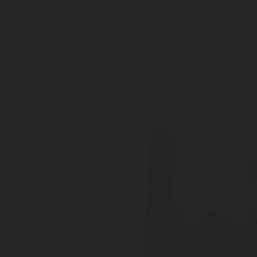

Category: 1


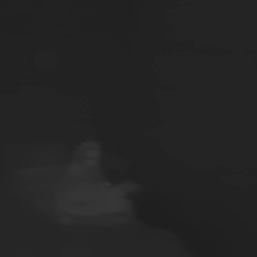

Category: 1


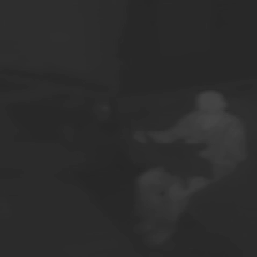

Category: 4


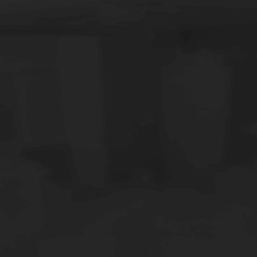

Category: 4


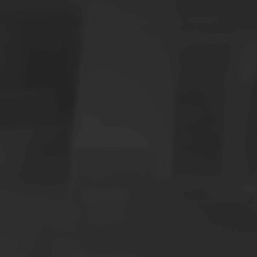

Category: 2


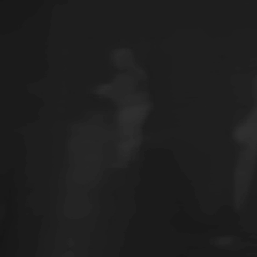

Category: 4


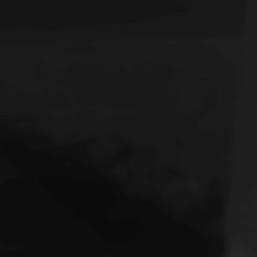

Category: 4


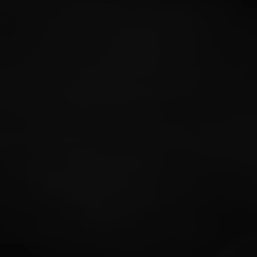

Category: 0


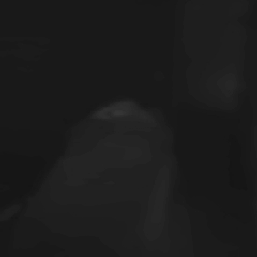

Category: 1


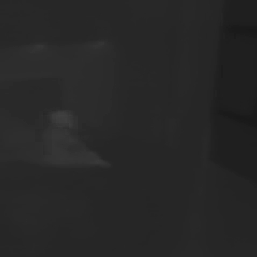

In [7]:
from PIL import Image
from IPython.display import display
import random

with open(training_file) as f:
    lines = f.readlines()

for l in random.sample(lines, 10):
    path = l.split()[0]
    img=Image.open(path)
    print "Category:",l.split()[1]
    display(img)

In [8]:
#save training dataset in h5py format
from training_utils import build_hdf5_thermal_image_dataset

if not os.path.exists(training_h5py_path):
    build_hdf5_thermal_image_dataset(training_file, (224,224), 
                         output_path=training_h5py_path,
                             mode='file', categorical_labels=True,
                             normalize=False, grayscale=True)

In [9]:
#save validation dataset in h5py format
from training_utils import build_hdf5_thermal_image_dataset

if not os.path.exists(val_h5py_path):
    build_hdf5_thermal_image_dataset(val_file, (224,224), 
                         output_path=val_h5py_path,
                             mode='file', categorical_labels=True,
                             normalize=False, grayscale=True)

In [ ]:
import tflearn, tensorflow as tf
from tflearn.layers.core import input_data, dropout, fully_connected,reshape
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import batch_normalization#local_response_normalization
#from tflearn.layers.estimator import regression

def model(input_placeholder=None):
    tf_data = input_placeholder or tf.placeholder(tf.float32, shape=(None, 224, 224))
    network = input_data(placeholder=tf_data)
    
    network = reshape(network, [-1,224,224,1])
    
    network = conv_2d(network, 96, 7, strides=2, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = batch_normalization(network)
    
    #network = local_response_normalization(network)
    network = conv_2d(network, 256, 5, strides=2, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = batch_normalization(network)
    
    #network = local_response_normalization(network)
    network = conv_2d(network, 384, 3, activation='relu')
    network = conv_2d(network, 384, 3, activation='relu')
    
    network = conv_2d(network, 256, 3, activation='relu')
    network = max_pool_2d(network, 3, strides=2)
    network = batch_normalization(network)
    
    #network = local_response_normalization(network)
    network = fully_connected(network, 5, activation='softmax')
    
    return network, tf_data

name = datetime.strftime(datetime.now(),'%Y-%m-%d_%H%M%S')
model_dir = "/workspace/data/thermix_data/tf_training"

tf.train.SummaryWriter(model_dir)
tflearn.config.init_training_mode()

# Model variables
#The network to be used
net, X_ph = model()
Y_ph = tf.placeholder(tf.float32, [None, 5])

loss = tflearn.categorical_crossentropy(net, Y_ph)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(net, 1), tf.argmax(Y_ph, 1)), tf.float32), name='Accuracy')
optimizer = tflearn.optimizers.Adam(learning_rate=0.001)
step = tflearn.variable("step", initializer='zeros', shape=[])
batch_size = 512
optimizer.build(step_tensor=step)
optim_tensor = optimizer.get_tensor()
epochs = 500

# Define a training op (op for backprop, only need 1 in this model)
trainop = tflearn.TrainOp(loss=loss, optimizer=optim_tensor,metric=accuracy, batch_size=batch_size, step_tensor=step)

trainer = tflearn.Trainer(train_ops=trainop, 
                          tensorboard_dir=model_dir, 
                          tensorboard_verbose=0, 
                          checkpoint_path=os.path.join(model_dir, name, 'checkpoint')
                         )

import h5py
h5f = h5py.File(training_h5py_path)
X = h5f['X']
Y = h5f['Y']

v_h5f = h5py.File(val_h5py_path)
v_X = v_h5f['X']
v_Y = v_h5f['Y']

trainer.fit({X_ph:X, Y_ph:Y},
            val_feed_dicts={X_ph:v_X,Y_ph:v_Y},
            shuffle_all=True,
            n_epoch=epochs,
            show_metric=True,
            snapshot_step=False,
            snapshot_epoch=True,
            run_id=name)

# Training
#model = tflearn.DNN(network, checkpoint_path='model_alexnet',
#                    max_checkpoints=1, tensorboard_verbose=2)
#model.fit(X, Y, n_epoch=1000, validation_set=0.1, shuffle=True,
#          show_metric=True, batch_size=64, snapshot_step=200,
#snapshot_epoch=False, run_id='alexnet_oxflowers17')